In [122]:
# embedding matice má v řádcích embeddingy (1 řádek - 1 token)
# vizualizovat umapem a olabelovat páry

In [123]:
checkpoint_path = "/mnt/raid/data/Hyner_Petr/rl/rl_basic_transformer/data/cc/wnl5hyny/checkpoints/epoch=99-step=406237.ckpt" # #2l
#checkpoint_path = "/mnt/raid/data/Hyner_Petr/rl/rl_basic_transformer/data/cc/aqmcef34/checkpoints/epoch=4-step=7500.ckpt" # 2l

In [124]:
import wandb
from tqdm import tqdm

In [125]:
import torch
from lightning import LightningModule
from models import GPT, GPTConfig, CausalSelfAttention
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

class NanoGPT(LightningModule):
    def __init__(
        self,
        vocab_size: int,
        block_size: int,
        n_layer: int = None,
        n_head: int = None,
        n_embd: int = None,
        dropout: float = 0.0,
        weight_decay: float = 0.1,
        learning_rate: float = 3e-4,
        betas: tuple = (0.9, 0.95)
    ):
        super().__init__()
        self.betas = betas
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.config = GPTConfig(vocab_size=vocab_size, block_size=block_size, n_layer=n_layer, n_head=n_head, n_embd=n_embd, dropout=dropout)
        self.gpt = GPT(self.config)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor = None) -> torch.Tensor:
        return self.gpt(idx, targets)

    def get_attention_map(self, idx: torch.Tensor):
        """
        Get the attention map for a single example.
        """
        self.attention_map = None

        def hook_fn(module, input, output):
            self.attention_map = output[1].detach() 

        first_attn_layer = self.gpt.transformer.h[0].attn
        handle = first_attn_layer.register_forward_hook(hook_fn)

        # Forward pass
        with torch.no_grad():
            self(idx)

        # Remove the hook
        handle.remove()

        return self.attention_map
## FCE:

def load_trained_model(checkpoint_path, vocab_size, block_size, n_layer, n_head, n_embd):
    model = NanoGPT(
        vocab_size=vocab_size,
        block_size=block_size,
        n_layer=n_layer,
        n_head=n_head,
        n_embd=n_embd
    )
    
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    
    model.eval()
    
    return model
    
def load_data(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

In [126]:
loaded_model = load_trained_model(
    checkpoint_path,
    vocab_size=106,
    block_size=32,
    n_layer=2,
    n_head=1,
    n_embd=16,
)
print("Model loaded from local checkpoint")

input_ids = torch.randint(0, 80, (1, 8))  # Random input
with torch.no_grad():
    output, _ = loaded_model(input_ids)
print("Output shape:", output.shape)

number of parameters: 0.01M
Model loaded from local checkpoint
Output shape: torch.Size([1, 1, 106])


In [127]:
data = load_data("new_data.pkl")
test_data = data["test"]

In [128]:
def inference_on_test_set(model, test_data):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = len(test_data)
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for sample in tqdm(test_data):
            input_ids = torch.tensor(sample['input']).unsqueeze(0)  # Add batch dimension
            true_output = sample['target_idx']
            
            input_ids = input_ids.to(next(model.parameters()).device)
            
            logits, _ = model(input_ids)
            predicted_output = logits.argmax(dim=-1).item()
            
            correct_predictions += (predicted_output == true_output)
            
            predictions.append(predicted_output)
            true_labels.append(true_output)
    
    accuracy = correct_predictions / total_samples
    return accuracy, predictions, true_labels

In [129]:
accuracy,_,_= inference_on_test_set(loaded_model, test_data)
accuracy

100%|██████████| 40/40 [00:00<00:00, 959.52it/s]


1.0

In [130]:
def inference_on_single_sample(model, sample):
    model.eval()  # Set the model to evaluation mode
    
    input_ids = torch.tensor(sample['input']).unsqueeze(0)  # Add batch dimension
    true_output = sample['target_idx']
    
    input_ids = input_ids.to(next(model.parameters()).device)
    
    with torch.no_grad():
        logits, _ = model(input_ids)
        predicted_output = logits.argmax(dim=-1).item()
    
    is_correct = (predicted_output == true_output)
    
    return is_correct, f"{predicted_output=}", f"{true_output=}"


In [131]:
loaded_model.gpt.transformer.wte.weight.shape

torch.Size([106, 16])

In [132]:
loaded_model.gpt.transformer.wte.weight

Parameter containing:
tensor([[-0.0582, -0.0037, -0.0502,  ...,  0.0521, -0.0388,  0.0018],
        [-0.0548,  0.0024, -0.0565,  ...,  0.0499, -0.0362, -0.0045],
        [ 0.0372, -0.0055, -0.0473,  ...,  0.0052, -0.0210, -0.0526],
        ...,
        [ 0.0014,  0.0856, -0.3456,  ..., -0.1409,  0.0897, -0.0200],
        [ 0.0014,  0.0856, -0.3456,  ..., -0.1409,  0.0897, -0.0200],
        [ 0.0014,  0.0856, -0.3456,  ..., -0.1409,  0.0897, -0.0200]],
       requires_grad=True)

In [133]:
loaded_model.gpt.transformer.h[0].attn

CausalSelfAttention(
  (c_attn): Linear(in_features=16, out_features=48, bias=True)
  (c_proj): Linear(in_features=16, out_features=16, bias=True)
  (attn_dropout): Dropout(p=0.0, inplace=False)
  (resid_dropout): Dropout(p=0.0, inplace=False)
)

In [134]:
loaded_model

NanoGPT(
  (gpt): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(106, 16)
      (wpe): Embedding(32, 16)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-1): 2 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=16, out_features=48, bias=True)
            (c_proj): Linear(in_features=16, out_features=16, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=16, out_features=64, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=64, out_features=16, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=16, out_features=106, bias=False)
  )
)

In [148]:
index = 1

In [149]:
test_data[index]["input"]

[13, 70, 2, 40, 9, 5, 52, 42, 58, 11, 35, 43, 65, 33, 22, 1, 76, 46, 18, 9]

In [150]:
lst = [13, 70, 2, 40, 9, 6, 52, 42, 58, 11, 35, 43, 65, 33, 22, 1, 76, 46, 18, 9]

In [151]:
test_data[index]["orig_idx"]

15

In [152]:
test_data[index]["target_idx"]

99

In [153]:
inference_on_single_sample(loaded_model, test_data[index])

(True, 'predicted_output=99', 'true_output=99')

torch.Size([1, 1, 20, 20])
torch.Size([20, 20])
tensor([[0.0000e+00, 1.9697e-03, 4.7515e-05, 4.4166e-09, 1.0284e-06, 2.7702e-10,
         1.5084e-08, 4.8356e-09, 3.6440e-05, 2.8232e-05, 5.0908e-06, 1.6949e-08,
         1.3102e-09, 6.0029e-06, 9.7582e-07, 2.0646e-06, 7.9590e-12, 3.3463e-03,
         3.1720e-06, 9.9455e-01],
        [2.8538e-01, 0.0000e+00, 9.6798e-02, 6.6151e-03, 8.7933e-05, 2.1375e-01,
         7.7474e-03, 4.3254e-02, 8.1893e-04, 3.5010e-03, 2.0527e-04, 3.2529e-02,
         7.7591e-05, 4.2469e-05, 2.2883e-01, 1.4355e-02, 1.3580e-03, 8.7806e-03,
         1.1385e-02, 4.4482e-02],
        [2.7907e-03, 2.5914e-09, 0.0000e+00, 7.9509e-05, 3.9901e-08, 9.7862e-01,
         1.0594e-03, 9.1665e-05, 2.6569e-04, 4.8496e-08, 6.5255e-07, 2.1119e-05,
         1.4197e-08, 1.0716e-09, 1.0999e-02, 2.3550e-03, 3.9860e-06, 8.5186e-08,
         1.5980e-04, 3.5527e-03],
        [3.5291e-08, 4.5023e-03, 3.8768e-03, 0.0000e+00, 9.8045e-06, 1.9004e-07,
         4.6143e-09, 2.3376e-06, 4.5243e

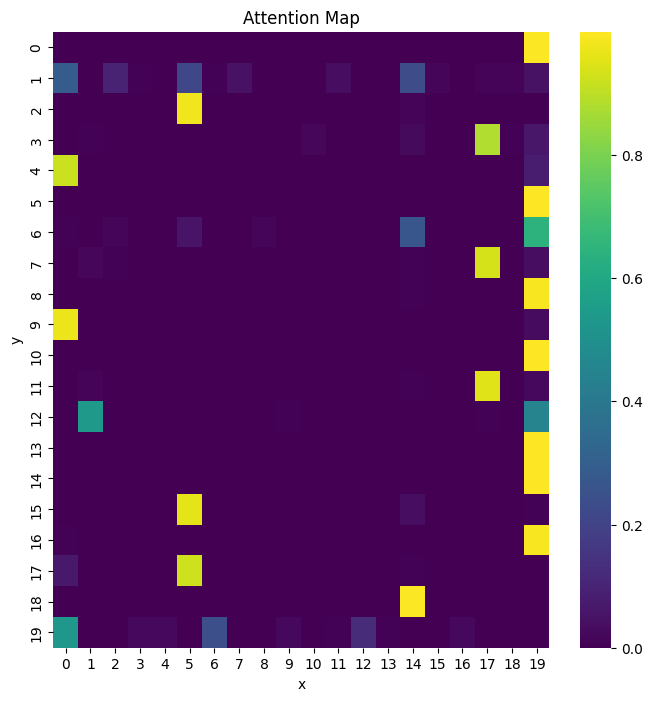

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

def visualize_attention_map(model, input_ids):
    model.eval()
    with torch.no_grad():
        attention = model.get_attention_map(input_ids)
    print(attention.shape)
    attention = attention.squeeze()
    print(attention.shape)
    print(attention)

    plt.figure(figsize=(8, 8))
    sns.heatmap(attention, cmap='viridis')
    plt.title("Attention Map")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

input_ids = torch.tensor(test_data[index]["input"]).unsqueeze(0)
visualize_attention_map(loaded_model, input_ids)

In [143]:
embeddings = loaded_model.gpt.transformer.wte.weight
embeddings.shape

torch.Size([106, 16])

In [144]:
import umap
from sklearn.decomposition import PCA
embeddings = loaded_model.gpt.transformer.wte.weight
embeddings = embeddings.detach().numpy()[:73]

def get_embedding_umap(embeddings):
    reducer = umap.UMAP()
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

def get_embedding_pca(embeddings):
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    return pca_embeddings

# Call the functions to get UMAP and PCA embeddings
umap_embeddings = get_embedding_umap(embeddings)
pca_embeddings = get_embedding_pca(embeddings)

# Print the shapes of the embeddings
print(f"UMAP embeddings shape: {umap_embeddings.shape}")
print(f"PCA embeddings shape: {pca_embeddings.shape}")


UMAP embeddings shape: (73, 2)
PCA embeddings shape: (73, 2)


In [145]:
embeddings

array([[-0.05819352, -0.00369538, -0.05021367, ...,  0.05208622,
        -0.0387732 ,  0.00180665],
       [-0.05482261,  0.00236286, -0.05652359, ...,  0.04985138,
        -0.03622702, -0.00451653],
       [ 0.03722161, -0.00554046, -0.0472555 , ...,  0.00524191,
        -0.02099082, -0.0525617 ],
       ...,
       [ 0.12718418, -0.03562572, -0.06022569, ..., -0.07411212,
         0.02451001, -0.04219978],
       [ 0.12383503, -0.03834128, -0.04818722, ..., -0.0781334 ,
         0.0241628 , -0.04949028],
       [-0.02671921, -0.04213225, -0.03443642, ..., -0.01755139,
         0.05698747, -0.00583979]], dtype=float32)

In [146]:
embeddings.shape

(73, 16)

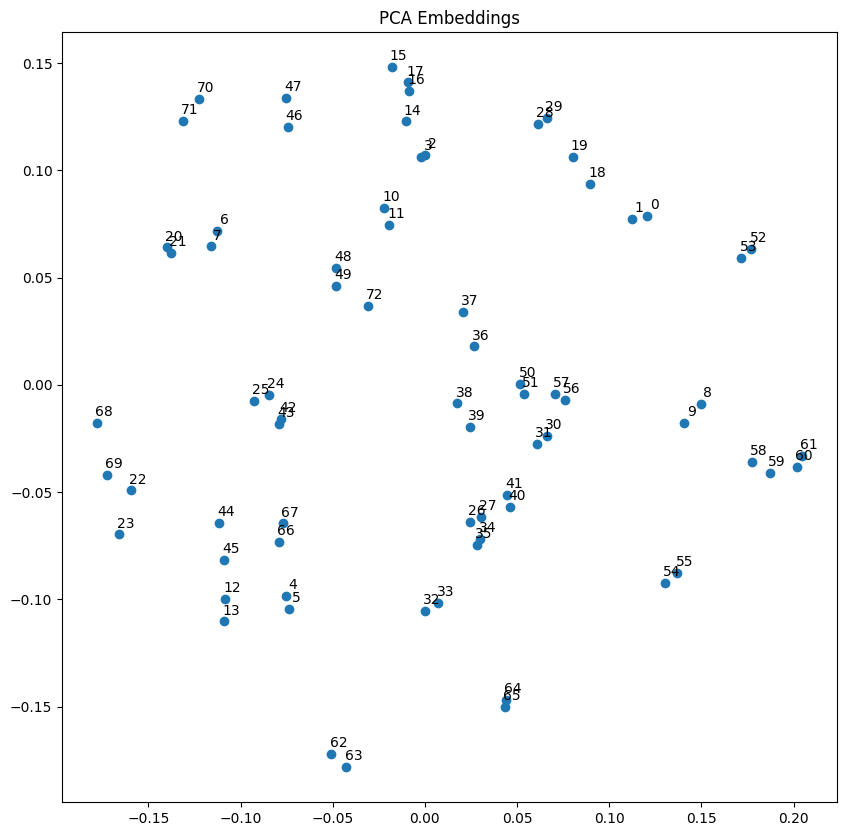

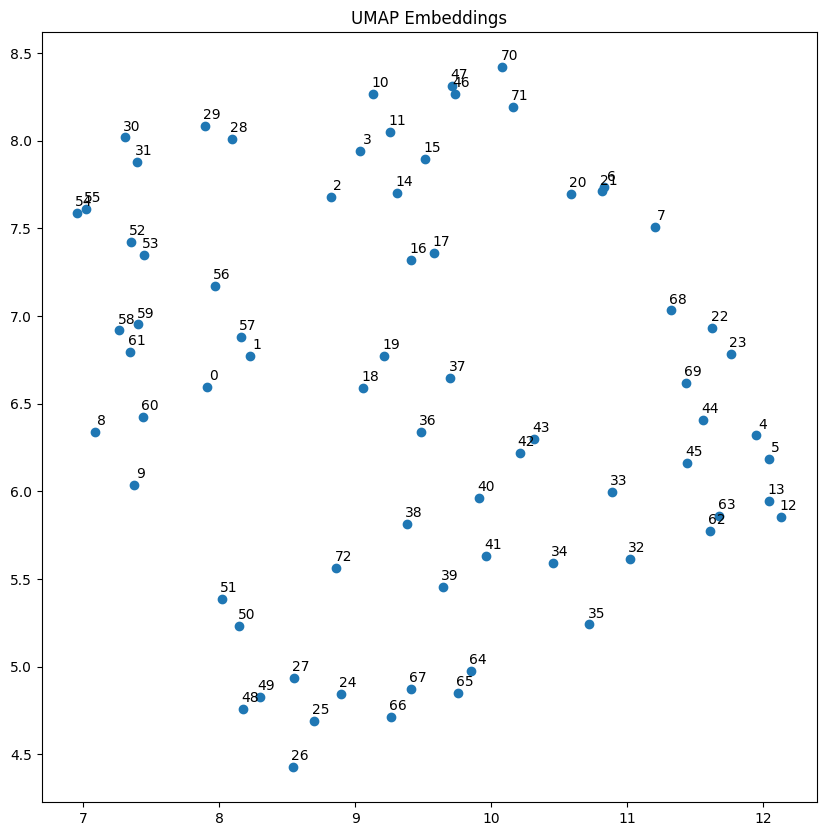

In [147]:
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])
    plt.title(title)
    labels = list(range(len(embeddings)))
    for i in range(len(embeddings)):
        plt.annotate(labels[i], (embeddings[i, 0], embeddings[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')
    plt.show()

# Call the function to visualize the PCA embeddings
visualize_embeddings(pca_embeddings, "PCA Embeddings")
visualize_embeddings(umap_embeddings, "UMAP Embeddings")